In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import math
import matplotlib.pyplot as plt

from tqdm import tqdm_notebook, tnrange

In [2]:
import datetime
now = datetime.datetime.now().isoformat()

In [3]:
torch.manual_seed(1)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print(f"device:\n{device}\n")

# LSTM 

/usr/local/lib/python3.7/dist-packages/matplotlib/figure.py:448: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())



CPU times: user 22.3 s, sys: 6.78 s, total: 29.1 s
Wall time: 22.1 s


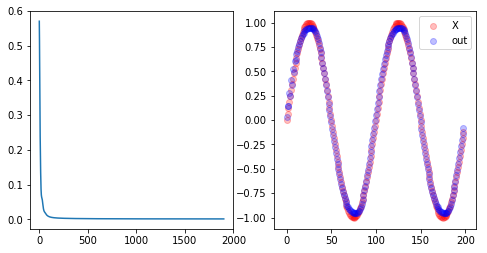

In [4]:
%%time

# Using `widget` here instead of `notebook` or `inline` to allow for dynamic updating in Jupter Lab 
%matplotlib inline

EPOCHS = 2000
period_samples = 100
periods_count = 2
inputs = torch.tensor([[[math.sin(2 * math.pi * x / float(period_samples))]] for x in
                       range(period_samples * periods_count)])

# LST model
model = nn.LSTM(input_size=1, hidden_size=1)
model.to(device)

loss_function = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)

X = inputs[:-1]
X_gpu = X.to(device)

Y = inputs[1:]
Y_gpu = Y.to(device)

hidden = (torch.zeros(1, 1, 1).to(device), torch.zeros(1, 1, 1).to(device))
losses = []

# tnrange, is a wrapper for tqdm_notebook(range(),xxx)
# See https://pypi.org/project/tqdm/#manual
with tnrange(EPOCHS, desc="epoch") as t:
    fig = plt.figure()
    ax_loss = fig.add_subplot(121)
    ax_fit = fig.add_subplot(122)
    plt.ioff()
    fig.show()
    fig.canvas.draw()
    
    for epoch in t:

        # Forward
        out, _ = model(X_gpu, hidden)

        # Compute the loss, gradients, and update the parameters by calling optimizer.step()
        optimizer.zero_grad()
        loss = loss_function(out, Y_gpu)
        loss.backward()
        optimizer.step()
        
        losses.append(loss.item())
        
        t.set_postfix(loss=loss.item())
        
        if epoch % 100 == 0:
            ax_loss.clear()
            ax_loss.plot(losses)
            ax_fit.clear()
            ax_fit.scatter(range(period_samples * periods_count - 1), X.numpy(), color='red', alpha=0.25, label="X")
            ax_fit.scatter(range(period_samples * periods_count - 1), out.cpu().detach().numpy(), color='blue', alpha=0.25, label="out")
            ax_fit.legend()
            fig.canvas.draw()
            
            
    # Set a larget at the to workaround a Juupyter lab matplotlib widget bug with live updateing large plots being truncated.
    fig.set_size_inches(8,4)
    

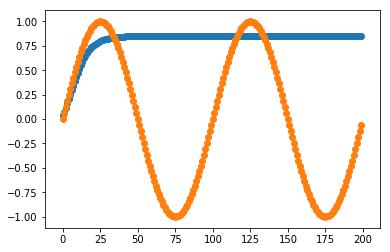

In [5]:
hidden = (torch.zeros(1, 1, 1).to(device), torch.zeros(1, 1, 1).to(device))
X_range = [i for i in range(200)]
Y_hat = []
last_prediction = torch.zeros(1, 1, 1, dtype=torch.float32).to(device)
for x in X_range:
    out, hidden = model(last_prediction, hidden)
    last_prediction = out
    Y_hat.append(out.item())

plt.figure()
plt.scatter(X_range,Y_hat)
plt.scatter(X_range, inputs.numpy())
plt.show()

# LSTMCell